## Loading training and validation data

We devided the training data to 2 different datasets.
- Training data: The training data will be used to train the model and recalculate the weights 
- Validation data: The validation data will be used to see the network's success on new data.

We use this method in order to prevent over fitting our model. 
The success of our model will be messured by It's preformmance on the Validation data.

* We will set rotation in order to create a larger data set.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

image_size = (128,128)
batch_size = 32

training_data_dir = r'C:\Users\Karin\Desktop\ML\Data'
validation_data_dir = r'C:\Users\Karin\Desktop\ML\Test'

# For Google Colab:
#from google.colab import drive

#drive.mount('/gdrive')

#training_data_dir = r'/gdrive/My Drive/train'

#train_datagen = ImageDataGenerator(validation_split=0.2) # set validation split

#train_generator = train_datagen.flow_from_directory(
#    training_data_dir,
#    target_size=image_size,
#    batch_size=batch_size,
#    color_mode='rgb',
#    class_mode='categorical',
#    shuffle=True,
#    subset='training') # set as training data

#validation_generator = train_datagen.flow_from_directory(
#    training_data_dir,
#    target_size=image_size,
#    batch_size=batch_size,
#    color_mode='rgb',
#    class_mode='categorical',
#    shuffle=True,
#    subset='validation') # set as validation data





train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")


Found 35416 images belonging to 100 classes.
Found 3986 images belonging to 100 classes.


## Display some of the photos

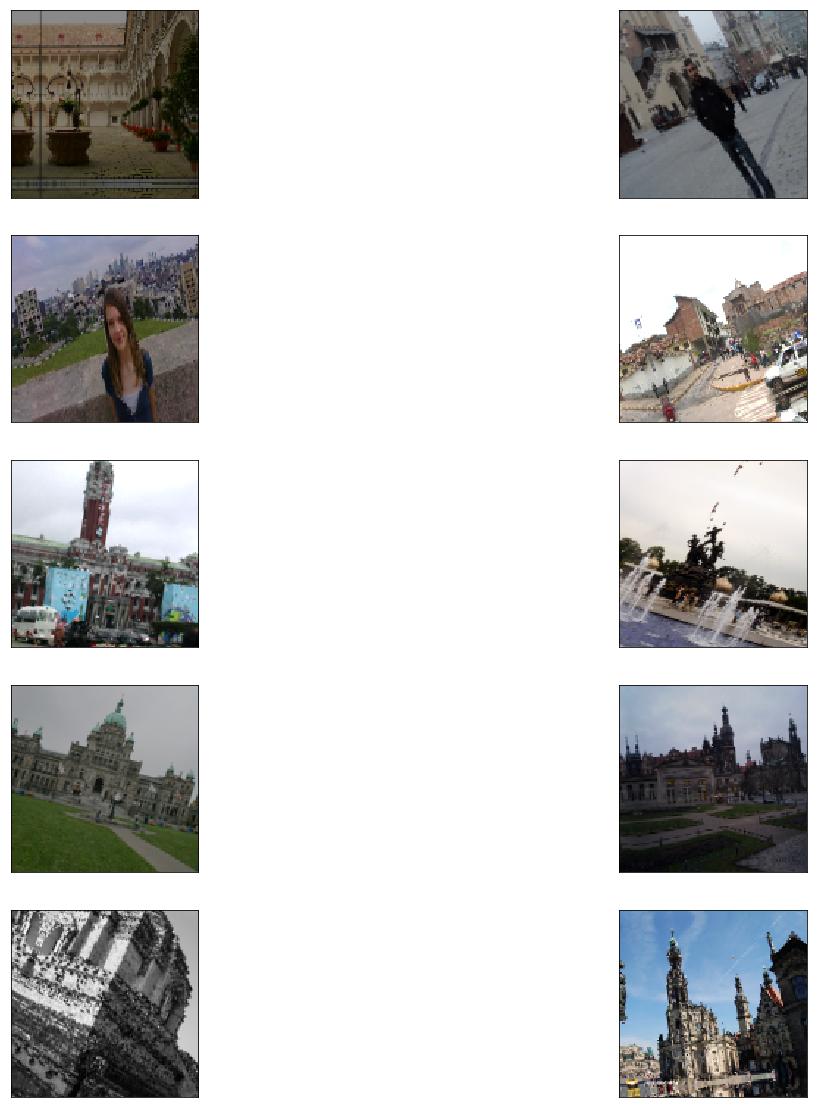

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

# Creating our model

In [14]:
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

amountOfClasses = 100;

model = Sequential()

# 1 Layer
model.add(Conv2D(64, (16,16), input_shape = (image_size[0], image_size[1], 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2 Layer
model.add(Conv2D(128, (8,8)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3 Layer
model.add(Conv2D(256, (4,4)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 4 Layer
model.add(Conv2D(512, (2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatening the data
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))

#output layer
model.add(Dense(amountOfClasses))
model.add(Activation('softmax'))

#Show the summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 113, 113, 64)      49216     
_________________________________________________________________
activation_4 (Activation)    (None, 113, 113, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 49, 49, 128)       524416    
_________________________________________________________________
activation_5 (Activation)    (None, 49, 49, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 256)       524544    
__________

## Setting the optimizer

In [15]:
import tensorflow.keras
from tensorflow.keras.optimizers import SGD
adamOptimizer = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss = 'categorical_crossentropy', 
             optimizer= adamOptimizer,
             metrics=['accuracy'])

## Step Size

In [16]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

1106


## Creating Loss and Accuracy history callbacks

In [17]:
class LossAccHisotry(Callback):
    def on_train_begin(self,logs={}):
        self.loss_history = []
        self.accuracy_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss_history.append(logs.get('val_loss'))
        self.val_accuracy_history.append(logs.get('val_acc'))
        self.loss_history.append(logs.get('loss'))
        self.accuracy_history.append(logs.get('acc'))
    
history = LossAccHisotry()## Setting the network saving time periods

# Ignoring images with a bad format

In [18]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Setting the network saving time periods

In [19]:
import time

networkfileName = r"C:\Users\Karin\Desktop\ML\Final Project\deep_NN_exp1_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

## Training the model

In [20]:
NumberOfEpochs = 5;
ValidationSplits = 0.1;
#validation_split=ValidationSplits,

model.fit_generator(generator = train_generator,
                   steps_per_epoch= step_size_train,
                   epochs= NumberOfEpochs,
                   callbacks= [history, checkpoint],
                   validation_data= validation_generator)

Epoch 1/5
  34/1107 [..............................] - ETA: 1:48:56 - loss: 15.9612 - acc: 0.0092

C:\Users\Karin\Anaconda3\lib\site-packages\PIL\Image.py:930: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


120/125 [===========================>..] - ETA: 12s - loss: 15.9586 - acc: 0.0099

C:\Users\Karin\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3300917248 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Karin\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5898240 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Karin\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4294901760 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Karin\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 589824 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Karin\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EX

125/125 [==============================] - 315s 3s/step - loss: 15.9650 - acc: 0.0095

Epoch 00001: val_acc improved from -inf to 0.00953, saving model to C:\Users\Karin\Desktop\ML\Final Project\deep_NN_exp1_1552076813.h5
1107/1107 [==============================] - 7362s 7s/step - loss: 15.9631 - acc: 0.0096 - val_loss: 15.9650 - val_acc: 0.0095
Epoch 2/5
125/125 [==============================] - 310s 2s/step - loss: 15.9650 - acc: 0.0095

Epoch 00002: val_acc did not improve from 0.00953
1107/1107 [==============================] - 7212s 7s/step - loss: 15.9625 - acc: 0.0097 - val_loss: 15.9650 - val_acc: 0.0095
Epoch 3/5
125/125 [==============================] - 302s 2s/step - loss: 15.9650 - acc: 0.0095

Epoch 00003: val_acc did not improve from 0.00953
1107/1107 [==============================] - 7195s 6s/step - loss: 15.9623 - acc: 0.0097 - val_loss: 15.9650 - val_acc: 0.0095
Epoch 4/5
125/125 [==============================] - 315s 3s/step - loss: 15.9650 - acc: 0.0095

Epoch 

# Loss and Accuracy graphs

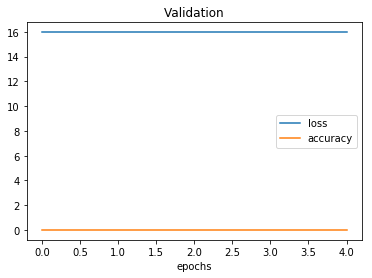

In [21]:
import matplotlib.pyplot as plt
x = range(0, len(history.val_loss_history))
plt.plot(x, history.val_loss_history)
plt.plot(x, history.val_accuracy_history)
plt.xlabel('epochs')
plt.title('Validation')
plt.legend(['loss', 'accuracy'])

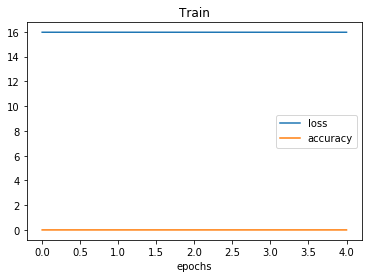

In [22]:
import matplotlib.pyplot as plts
x = range(0, len(history.loss_history))
plt.plot(x, history.loss_history)
plt.plot(x, history.accuracy_history)
plt.xlabel('epochs')
plt.title('Train')
plt.legend(['loss', 'accuracy'])